In [2]:
# import the necessary packages
import json
import numpy as np
# define the json training file
jsonTrainFile = "./data/transforms_train.json"
# open the file and read the contents of the file
with open(jsonTrainFile, "r") as fp:
    jsonTrainData = json.load(fp)
# print the content of the json file
print(f"[INFO] Focal length train: {jsonTrainData['camera_angle_x']}")
print(f"[INFO] Number of frames train: {len(jsonTrainData['frames'])}")

[INFO] Focal length train: 0.6911112070083618
[INFO] Number of frames train: 100


In [3]:
def getImagePathsAndTMs(jsonData, basePath):
    imagePaths = [] 
    C2WTMs = [] 
    
    for frame in jsonData["frames"]:
        imagePaths.append(basePath + r"/" + frame["file_path"][2:] + ".png")
        C2WTMs.append(frame["transform_matrix"])
        
    return imagePaths,C2WTMs
        
imagePaths,c2wTMs = getImagePathsAndTMs(jsonData=jsonTrainData, basePath=r"./data")
    
    

In [4]:
from torch.utils.data import Dataset
import torch 
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import Resize


class SceneData(Dataset):
    """Scene dataset class"""

    def __init__(self, imagePaths, imageWidth, imageHeight, transform=None):
        """
        Args:
            root_dir (string): Path to the directory which contains all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.imagePaths = imagePaths
        self.imageWidth = imageWidth
        self.imageHeight = imageHeight
        self.transform = transform
        # self.c2wTMs = c2wTMs

    def __len__(self):
        return len(self.imagePaths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        fname = self.imagePaths[idx]
        # c2wTM = self.c2wTMs[idx]

        image = read_image(fname, mode = ImageReadMode.RGB)
        
        if self.transform:
            image = self.transform(image)

        # return image, c2wTM
        return image

In [5]:
BATCH_SIZE = 5
from torch.utils.data import DataLoader
from torchvision import transforms

data_transforms = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Resize((800, 800))
])

# image_dataset = SceneData(imagePaths= imagePaths, c2wTMs=c2wTMs, imageHeight=800, imageWidth= 800, transform = data_transforms)
image_dataset = SceneData(imagePaths= imagePaths, imageHeight=800, imageWidth= 800, transform = data_transforms)
train_dataloader = DataLoader(image_dataset, batch_size=BATCH_SIZE, shuffle=False)


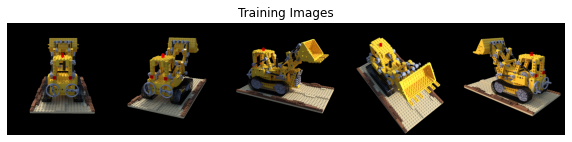

In [6]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils


real_batch = next(iter(train_dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0:5], padding=2, normalize=False).cpu(),(1,2,0)))

In [7]:
class RayData(Dataset):
    def __init__(self, c2wTMs, focalLength, imageWidth, imageHeight, near, far, n):
        
        self.c2wTMs = c2wTMs
        self.focalLength = focalLength        
        self.imageWidth = imageWidth
        self.imageHeight = imageHeight
        self.near = near
        self.far = far
        self.n = n

    def __len__(self):
        return len(self.c2wTMs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        c2wTM = torch.Tensor(self.c2wTMs[idx])
        rotationMatrix = c2wTM[:3, :3]
        translationMatrix = c2wTM[:3, -1]

        (x, y) = torch.meshgrid(
			torch.arange(start=0, end=self.imageWidth, dtype=torch.float32),
            torch.arange(start=0, end=self.imageHeight, dtype=torch.float32),
			indexing="xy",
		)
        
        x = x.t()
        y = y.t()
        
        #Converting into Camera Co-ordinates
        dirs = torch.stack([(x - self.imageWidth * 0.5) / self.focalLength, - (y - self.imageHeight * 0.5) / self.focalLength, -torch.ones_like(x)], -1)
        
        #Getting the dvector
        cameraCoords = dirs[..., np.newaxis, :] #Getting the Camera Co-ordinates
        directionVector =  torch.sum(cameraCoords * rotationMatrix, dim=-1) #Calculating Direction Vector R X Camera Co-ordinates
        directionVector = directionVector / torch.norm(directionVector, dim=-1, keepdim=True) # Converting Directoion Vector into Unit Direction Vector
        
        # calculate the origin vector of the ray
        originVector = translationMatrix.expand(directionVector.shape)
		
    
        # Sample points from the ray 
        # Here we Sample points at regular intervals and then add noise taken from Uniform distribution 
        # This is done for better regularization 
        tVals = torch.linspace(self.near, self.far, self.n)
        noise = torch.rand(size=list(originVector.shape[:-1]) + [self.n]) * ((self.far - self.near) / self.n)
        tVals = tVals + noise
                
        # if self.transform:
        #     image = self.transform(image)

        return originVector, directionVector, tVals
    

In [8]:
BATCH_SIZE = 5
from torch.utils.data import DataLoader
from torchvision import transforms


ray_dataset = RayData(c2wTMs = c2wTMs, focalLength=138.8888789, imageWidth  = 800, imageHeight = 800, near = 2, far = 6, n=32)
trainray_dataloader = DataLoader(ray_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
from torch.utils.data import Dataset
import torch 
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import Resize


class TotalSceneData(Dataset):
    """Scene dataset class"""

    def __init__(self, imagePaths, c2wTMs, imageWidth, imageHeight, focalLength, near, far, n, transform=None):
        """
        Args:
            root_dir (string): Path to the directory which contains all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.imagePaths = imagePaths
        self.c2wTMs = c2wTMs
        self.imageWidth = imageWidth
        self.imageHeight = imageHeight
        self.focalLength = focalLength
        self.near = near
        self.far = far
        self.n = n
        self.transform = transform

    def __len__(self):
        assert len(self.imagePaths) == len(self.c2wTMs)
        return len(self.imagePaths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        fname = self.imagePaths[idx]
        c2wTM = torch.Tensor(self.c2wTMs[idx])
        
        #Processing the Image
        image = read_image(fname, mode = ImageReadMode.RGB)
        
        if self.transform:
            image = self.transform(image)

        
        rotationMatrix = c2wTM[:3, :3]
        translationMatrix = c2wTM[:3, -1]

        (x, y) = torch.meshgrid(
			torch.arange(start=0, end=self.imageWidth, dtype=torch.float32),
            torch.arange(start=0, end=self.imageHeight, dtype=torch.float32),
			indexing="xy",
		)
        
        x = x.t()
        y = y.t()
        
        #Converting into Camera Co-ordinates
        dirs = torch.stack([(x - self.imageWidth * 0.5) / self.focalLength, - (y - self.imageHeight * 0.5) / self.focalLength, -torch.ones_like(x)], -1)
        
        #Getting the dvector
        cameraCoords = dirs[..., np.newaxis, :] #Getting the Camera Co-ordinates
        directionVector =  torch.sum(cameraCoords * rotationMatrix, dim=-1) #Calculating Direction Vector R X Camera Co-ordinates
        directionVector = directionVector / torch.norm(directionVector, dim=-1, keepdim=True) # Converting Directoion Vector into Unit Direction Vector
        
        # calculate the origin vector of the ray
        originVector = translationMatrix.expand(directionVector.shape)
		
    
        # Sample points from the ray 
        # Here we Sample points at regular intervals and then add noise taken from Uniform distribution 
        # This is done for better regularization 
        tVals = torch.linspace(self.near, self.far, self.n)
        noise = torch.rand(size=list(originVector.shape[:-1]) + [self.n]) * ((self.far - self.near) / self.n)
        tVals = tVals + noise
        
        return (image, originVector, directionVector, tVals)

In [10]:
BATCH_SIZE = 5
from torch.utils.data import DataLoader
from torchvision import transforms


TotalScene_dataset = TotalSceneData(imagePaths= imagePaths, c2wTMs = c2wTMs, focalLength=138.8888789, imageWidth  = 800, imageHeight = 800, near = 2, far = 6, n=32, transform = data_transforms)
TotalScene_dataloader = DataLoader(TotalScene_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
for data in TotalScene_dataloader:
    print(len(data))
    break

4


torch.Size([5, 3, 800, 800])
torch.Size([5, 800, 800, 3])
torch.Size([800, 800, 3])


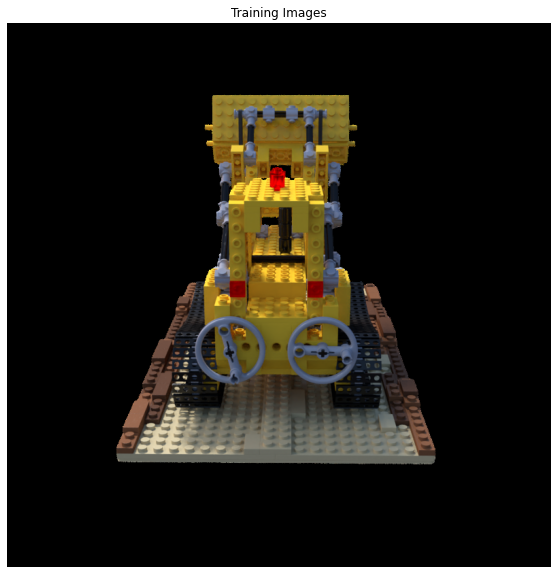

In [23]:
real_batch = next(iter(TotalScene_dataloader))
print(real_batch[0].size())
print(np.transpose(real_batch[0][0:5], (0,2,3,1)).size())
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training Images")
print(np.transpose(vutils.make_grid(real_batch[0][0], padding=2, normalize=False).cpu(),(1,2,0)).shape)
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][0], padding=2, normalize=False).cpu(),(1,2,0)))

In [15]:
a = torch.randn((500, 200, 10))
b = torch.randn((500, 1))

In [16]:
c = torch.cat([a, torch.unsqueeze(b, 1).repeat(1, 200, 1)], dim=2)
c.shape

torch.Size([500, 200, 11])

In [17]:
torch.__version__

'1.10.0'